# Introduction - Machine Learning and Deep learning Models


To have a better understanding the unemployment status, I looked a public dataset that encompasses various factors such as income, health, and employment status. While the Census Bureau database offers such datasets, with the time limit, me look into find an alternative in a public dataset. 

During my search, I discovered the Folktables package. This Python package provides access to datasets derived from the US Census, acilitating the benchmarking of machine learning algorithms. The paper can be found here https://arxiv.org/abs/2108.04884. 

For this project, I intend to extract a dataset using the Folktables package to investigate the unemployment status. Specifically, our objective is to predict whether an individual is employed based on various features such as age, education, and more. The dataset contains the states of Ohio for the year of 2018 which is the latest available year in the package. 



## Step 1: Download the data. 

In [87]:
#Import packages
import numpy as np
import pandas as pd
from folktables import ACSDataSource, ACSEmployment

#Using the Folktables package to get the desired dataset. 

db_source = ACSDataSource(survey_year=2018, horizon='1-Year', survey='person')
db = data_source.get_data(states=["OH"], download=True)
features, labels, _ = ACSEmployment.df_to_numpy(db)
df = pd.DataFrame(features)
df.columns = ACSEmployment.features
df[ACSEmployment.target] = labels

# Trimming the dataset.
# On the purpose of understanding more the unemployment landscape from the other project, we will only look at the age group of female from 25 to 55. 

df = df[(df["AGEP"] >= 25) & (df["AGEP"] <= 55) & (df["SEX"] == 2)]

df = df.drop(columns=["SEX"], axis=1)



#### The orginal data set size has 119,086 rows and 16 features. The label is ESR for the unemployment status:
ESR = False : Unemployed, 
ESR = True : Employed. 

MAR: Marital status

RELP: Relationship to the household reference person

DIS: Disability status

ESP: Employment status of parents

CIT: Citizenship status

MIG: Mobility status (whether the individual lived in the same house as 1 year ago)

MIL: Military service status

ANC: Ancestry recode

NATIVITY: Nativity (whether the individual is native or foreign-born)

DEAR: Hearing difficulty status

DEYE: Vision difficulty status

DREM: Cognitive difficulty status

RAC1P: Recoded detailed race code

#### On the purpose of understanding more the unemployment landscape from the other project, we will only look at the age group of female from 25 to 55. 

The data set is now of size 21923. 

Details on the description of the features is in the Appendix at the end of the file. 


# Step 2: Data Engineering.

To prepare the dataset we can follow the following steps:



- Checking for missing values: If there is missing 

    + Delete missing values.
    
    + Impute using various methos.

- Age Group: The age group will contain 25-29, 30-34, 35-44, 45-55.

- Categorical variables: 

    + Nominal: One hot coding.

    + Ordinal: Label encoding or Custom Mapping. 

- SCHL - Educational attainment: is already has the label encoding structure. This technique maps each category to a unique integer value.

- Nomial variables: 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'RAC1P'.


In [88]:
## Checking for missing values
df.isna().sum() # No missing value

##Create the Age Group 25-29, 30-34, 35-44, 45-55.

# Define the bins and labels for each age group. 
age_bins = [25, 30, 35, 45, 55]
age_labels = ["25-29", "30-34", "35-44", "45-55"]

# Add a new column 'Age_Group' to df based on age bins
df["AGE_GR"] = pd.cut(df["AGEP"], bins=age_bins, labels=age_labels, right=False)

# Drop the agep column in df
df_final = df.drop(columns=["AGEP"], axis=1)

df_final.head()


,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,RAC1P,ESR,AGE_GR
10,16.0,3.0,16.0,2.0,0.0,1.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,False,45-55
58,16.0,2.0,16.0,2.0,0.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,False,35-44
73,19.0,3.0,16.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,False,45-55
89,16.0,5.0,16.0,1.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,1.0,1.0,False,45-55
130,20.0,4.0,17.0,2.0,0.0,1.0,3.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,True,35-44


Now, we will drop the AgeP variable and create one hot coding for all the nominal categorical variables.

In [89]:
# One-hot-encoding
from sklearn.preprocessing import OneHotEncoder

# This is the  list of norminal variables that need to encode for ML models
var_names = ["MAR", "RELP", "DIS", 
             "ESP", "CIT", "MIG", 
             "MIL", "ANC", "NATIVITY",
             "DEAR", "DEYE", "DREM", 
             "RAC1P", "AGE_GR"]
# One hot coding
onehot = OneHotEncoder(drop="first")

one_hot_data = onehot.fit_transform(df_final[var_names]).toarray()

# Create a DataFrame with all the one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot_data, columns=onehot.get_feature_names_out(var_names))

# Combine the SCHL and ESR column into this one_hot_df to make the final data set for ML models
non_onehot_df = pd.DataFrame(df_final[["SCHL", "ESR"]])

# Reset indices for the one_hot data frame, if not the two dataframw will not concat correctly. 
one_hot_df.reset_index(drop=True, inplace=True)
non_onehot_df.reset_index(drop=True, inplace=True)

df_onehot_final = pd.concat([one_hot_df, non_onehot_df], axis=1)

df_onehot_final.head()

,MAR_2.0,MAR_3.0,MAR_4.0,MAR_5.0,RELP_1.0,RELP_2.0,RELP_3.0,RELP_4.0,RELP_5.0,RELP_6.0,...,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,AGE_GR_30-34,AGE_GR_35-44,AGE_GR_45-55,AGE_GR_nan,SCHL,ESR
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,False
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.0,False
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,False
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20.0,True


# Step 3: Using MLl models to predict the Employment status

This is a classification problem. We can use Logistic Regression, Decision Trees, Random Forest, Support Vector Machines (SVM), k-Nearest Neighbors (kNN), Naive Bayes, Neural Networks.

For the illustration purposes, we will use the Randome Forest  in this project. Logistic Regerssion, Random Forest and Decsion Tree are used.


## Slitting the data set to train and test set.

In [90]:
from sklearn.model_selection import train_test_split

# X = df_onehot_final without the ESR
# y = ESR column
X_train, X_test, y_train, y_test = train_test_split(df_onehot_final.iloc[:,:-1], df_onehot_final.iloc[:,-1], test_size=0.2, random_state=42)


In [110]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

rs_log_reg.best_params_

rs_log_reg.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


0.7833523375142531

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the Random Forest Classifier
unempl_rf = RandomForestClassifier()

# Define the hyperparameters grid to search
param_grids = {
    'n_estimators': [100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Gridsearch with cross-validation
grid_search = GridSearchCV(estimator=unempl_rf, param_grid=param_grids, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters on the training set
best_unempl_rf = RandomForestClassifier(**best_params, random_state=42)
best_unempl_rf.fit(X_train, y_train)

# Make predictions
y_pred = best_unempl_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)


Accuracy: 0.7881413911060433


<Axes: xlabel='depth', ylabel='Accuracy'>

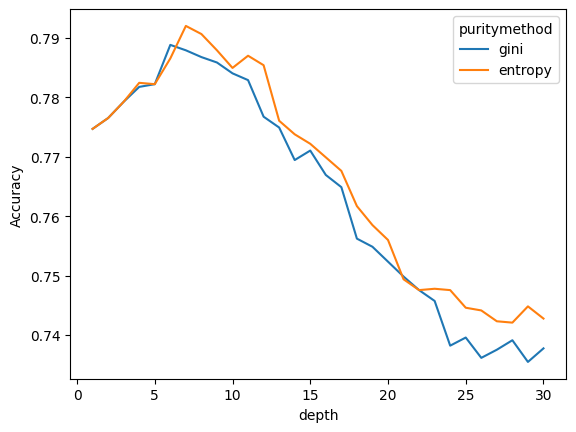

In [111]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

# Hyper Parameter Tuning - Decision Tree
ind = 1
crit = ['gini', 'entropy']
df_results = pd.DataFrame(columns = ['depth', 'puritymethod', 'Accuracy'])

for i in np.arange(1, 31):
  for j in crit:
    model = DecisionTreeClassifier(max_depth=i, criterion=j)
    model.fit(X_train, y_train)
    pred = model.predict (X_test)
    df_results.loc[ind] = [i, j, accuracy_score(y_test, pred)]
    ind+=1
sns.lineplot(x = 'depth', y = 'Accuracy', hue='puritymethod', data = df_results)

In [107]:
print('Best performing model - Decision Tree')      
print(df_results[df_results['Accuracy']==df_results['Accuracy'].max()])

Best performing model - Decision Tree
    depth puritymethod  Accuracy
14      7      entropy  0.792018


# Conclusion

We explore the dataset employing diverse ML techniques. Although there's slight improvement in accuracy with each model iteration, it remains below the 80% mark. To progress, a deeper comprehension of the domain is essential. This insight will guide the selection of appropriate data engineering techniques and aid in fine-tuning hyperparameters.

Moving forward in the project, our focus shifts to identifying crucial features affecting unemployment status. Leveraging the Random Forest model, we can extract these pivotal features, sheddg light on the underlying factors influencing employment outcomes.



# Appendix: Feature description.

#### This description comes from PUMS documentation:

AGEP - age person, numeric

SCHL - Educational attainment:

N/A - less than 3 years old

1 - No schooling completed

2 - Nursery school, preschool

3 - Kindergarten

4 - Grade 1

5 - Grade 2

6 - Grade 3

7 - Grade 4

8 - Grade 5

9 - Grade 6

10 - Grade 7

11 - Grade 8

12 - Grade 9

13 - Grade 10

14 - Grade 11

15 - 12th grade - no diploma

16 - Regular high school diploma

17 - GED or alternative credential

18 - Some college, but less than 1 year

19 - 1 or more years of college credit, no degree

20 - Associate’s degree

21 - Bachelor’s degree

22 - Master’s degree

23 - Professional degree beyond a bachelor’s degree

24 - Doctorate degree

MAR Character 1 - Marital status:

1 - Married

2 - Widowed

3 - Divorced

4 - Separated

5 - Never married or under 15 years old

RELP Character 2 - Relationship:

0 - Reference person

1 - Husband/wife

2 - Biological son or daughter

3 - Adopted son or daughter

4 - Stepson or stepdaughter

5 - Brother or sister

6 - Father or mother

7 - Grandchild

8 - Parent-in-law

9 - Son-in-law or daughter-in-law

10 - Other relative

11 - Roomer or boarder

12 - Housemate or roommate

13 - Unmarried partner

14 - Foster child

15 - Other nonrelative

16 - Institutionalized group quarters population

17- Noninstitutionalized group quarters population

DIS - Disability recode:

1 - With a disability

2 - Without a disability

ESP - Employment status of parents:

b - N/A (not own child of householder, and not child in subfamily)

1 - Living with two parents: both parents in labor force

2 - Living with two parents: Father only in labor force

3 - Living with two parents: Mother only in labor force

4 - Living with two parents: Neither parent in labor force

5 - Living with father: Father in the labor force

6 - Living with father: Father not in labor force

7 - Living with mother: Mother in the labor force

8 - Living with mother: Mother not in labor force

CIT - Citizenship status:

1 - Born in the U.S.

2 - Born in Puerto Rico, Guam, the U.S. Virgin Islands, or the Northern Marianas

3 - Born abroad of American parent(s)

4 - U.S. citizen by naturalization

5 - Not a citizen of the U.S.

MIG - Mobility status (lived here 1 year ago):

N/A - less than 1 year old

1 - Yes, same house (nonmovers)

2 - No, outside US and Puerto Rico

3 - No, different house in US or Puerto Rico

MIL - Military service:

N/A - less than 17 years old

1 - Now on active duty

2 - On active duty in the past, but not now

3 - Only on active duty for training in Reserves/National Guard

4 - Never served in the military

ANC - Ancestry recode:

1 - Single

2 - Multiple

3 - Unclassified

4 - Not reported

8 - Suppressed for data year 2018 for select PUMAs

NATIVITY - Nativity:

1 - Native

2 - Foreign born

DEAR - Hearing difficulty:

1 - Yes

2 - No

DEYE - Vision difficulty:

1 - Yes

2 - No

DREM - Cognitive difficulty:

N/A - Less than 5 years old

1 - Yes

2 - No

SEX - Sex:

1 - Male

2 - Female

RAC1P - Recoded detailed race code:

1 - White alone

2 - Black or African American alone

3 - American Indian alone

4 - Alaska Native alone

5 - American Indian and Alaska Native tribes specified or American Indian or Alaska Native, not specified and no other races

6 - Asian alone

7 - Native Hawaiian and Other Pacific Islander alone

8 - Some Other Race alone

9 - Two or More Races

ESR - target:

True - employed

False - unemployed